<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/TF_bayesian_model_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#@title Imports and Global Variables  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# optional disable warning
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
import pandas as pd

# plotting style
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize

notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/config/__init__.py'>

# modélisation bayésienne

à partir de données fictives d'ouverture des messages, on essaie de trouver la distribution vraisemblable des paramètres du modèle conduisant aux données.

On utilise l'algorithme de Hamilton Monte Carlo qui est implémenté dans Tensorflow probability

https://informatique-mia.inrae.fr/sites/informatique-mia.inra.fr.biosp-d7/files/oldfiles/RR2016_49.pdf

https://arxiv.org/pdf/1701.02434.pdf

## conclusion
pour l'exemple considéré - à condition que l'hypothèse du modèle sous-jacent soit correcte cf dataset (2) - on obtient un résultat très supérieur à ce que pourrait donner un simple lissage avec une fenêtre glissante

la modélisations de type seuil est peut-être trop radicale (cf dataset (1). pour un grand volume, on pourrait essayer de prendre une espèce de sigmoïde avec un paramètre de plus sur la largeur de transition

## dummy data +  visualisation

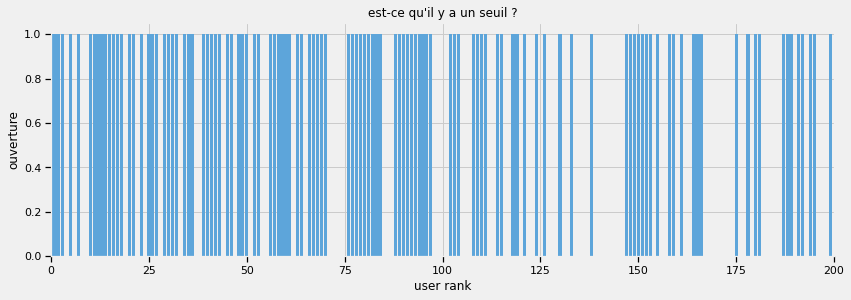

In [49]:
# dummy data

# petit dataset manuel (1)
count_data = tf.constant([
    1,1,0,1,1,0,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
], dtype=tf.float32)

# moyen dataset artificiel (2)
count_data = tf.concat([
    tfp.distributions.Bernoulli(probs=0.65, dtype=tf.float32).sample(100),
    tfp.distributions.Bernoulli(probs=0.35, dtype=tf.float32).sample(100)
    ], 0)


n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# visualisation
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("user rank")
plt.ylabel("ouverture")
plt.title("est-ce qu'il y a un seuil ?")
plt.xlim(0, n_count_data[0].numpy());

## modélisation

Pour les utilisateurs classés en décroissant, on note $C_i$ sa probab d'ouverture.
 
$$ C_i \sim \text{Bernoulli}(\text{prob}=\lambda)  $$
 
on modélise comme s'il y avait un seuil:
 
$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

On prend une probabilité a priori pour lambda  uniforme (ie a priori minimal sur la valeur de lambda)

$$
\begin{align}
&\lambda_1 \sim \text{ContinuousUniform}( [0,1] ) \\
&\lambda_2 \sim \text{ContinuousUniform}( [0,1] )
\end{align}
$$
 
De même pour  $\tau$ on prend un *uniform prior belief* 
$$
\begin{align}
& \tau \sim \text{DiscreteUniform(1,N) }
\end{align}
$$

On modélise cela dans [TensorFlow Probability](https://tensorflow.org/probability)

In [50]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    rv_lambda_1 = tfd.Uniform()
    rv_lambda_2 = tfd.Uniform()
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Bernoulli(probs=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


## Posterior sampler

définition et entrainement 
en utilisation l'implémentaiton Tensorflow de l'algo Hamilton Monte Carlo







In [51]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
num_results = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Sigmoid(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [52]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))
print("lambda1 samples:", lambda_1_samples)


acceptance rate: 0.6823499798774719
final step size: 0.022854512557387352
lambda1 samples: tf.Tensor([0.6946175  0.68336034 0.6734431  ... 0.711295   0.7168269  0.7168269 ], shape=(20000,), dtype=float32)


## Visualisation posterior sample

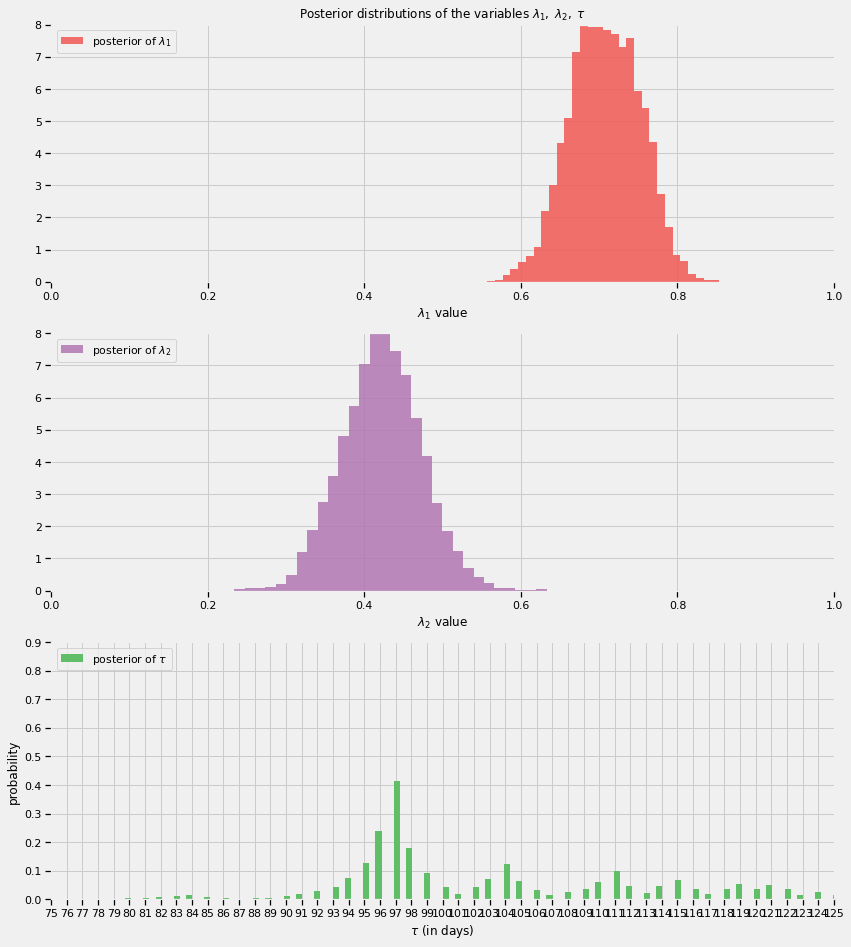

In [53]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.ylim([0, 8])
plt.xlim([0, 1])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([0, 1])
plt.ylim([0, 8])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)

plt.hist(tau_samples, bins=n_count_data[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], density=True) #  rwidth=5
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.ylim([0, 0.9])
plt.xlim([75, len(count_data) - 75])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

## analyse des postérieurs

L'espérance de l'utilisateur i est $\lambda_i$

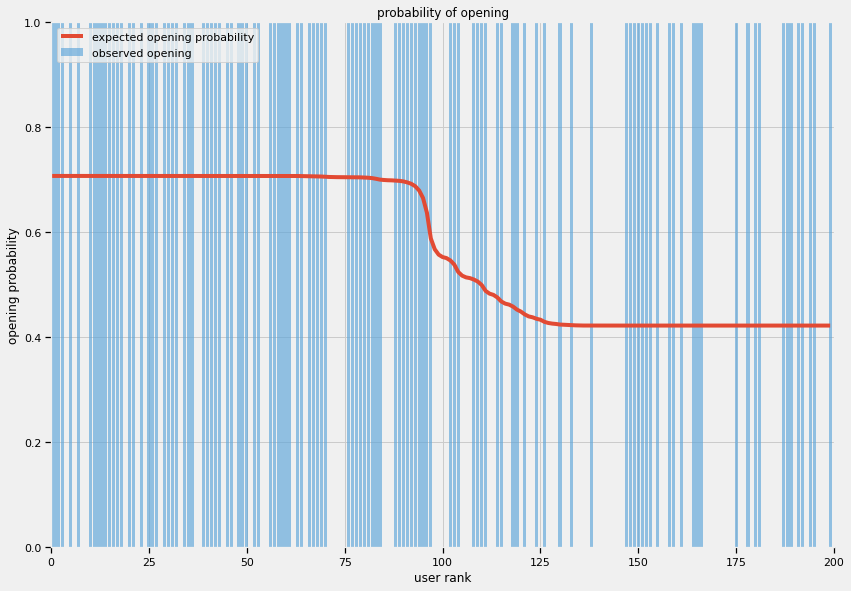

In [54]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_proba = tf.zeros(N_,n_count_data.shape[0]) #(10000,74)

plt.figure(figsize=(12.5, 9))

user_range = tf.range(0,n_count_data[0],delta=1,dtype = tf.int32)

user_range = tf.expand_dims(user_range,0)
user_range = tf.tile(user_range,tf.constant([N_,1]))

tau_samples_matrix = tf.expand_dims(tau_samples,0)
tau_samples_matrix = tf.transpose(tf.tile(tau_samples_matrix,tf.constant([user_range.shape[1],1])))

tau_samples_matrix = tf.cast(tau_samples_matrix,dtype=tf.int32)

#each value is true iff rank_filter < tau_sample value
rank_filter = user_range < tau_samples_matrix

lambda_1_samples_matrix = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_matrix = tf.transpose(tf.tile(lambda_1_samples_matrix,tf.constant([user_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([user_range.shape[1],1])))

expected_proba = ((tf.reduce_sum(lambda_1_samples_matrix*tf.cast(rank_filter,dtype=tf.float32),axis=0) + tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~rank_filter,dtype=tf.float32),axis=0))/N_)

plt.plot(range(n_count_data[0]), expected_proba, lw=4, color="#E24A33",
         label="expected opening probability")
plt.xlim(0, n_count_data.numpy()[0])
plt.xlabel("user rank")
plt.ylabel("opening probability")
plt.title("probability of opening")
plt.ylim(0, 1)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed opening")

plt.legend(loc="upper left");

## si au lieu de faire un modèle, on se contentait de lisser :

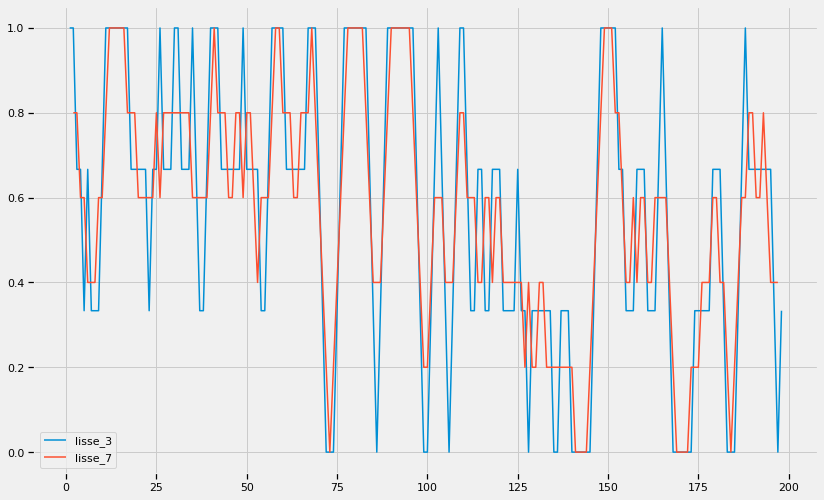

In [55]:
df = pd.DataFrame(count_data)
df["lisse_3"] = df[[0]].rolling(3, center=True).mean()
df["lisse_7"] = df[[0]].rolling(5, center=True).mean()
df["lisse_15"] = df[[0]].rolling(9, center=True).mean()
df["lisse_31"] = df[[0]].rolling(21, center=True).mean()
df[["lisse_3","lisse_7"]].plot(figsize=(12.5, 8))

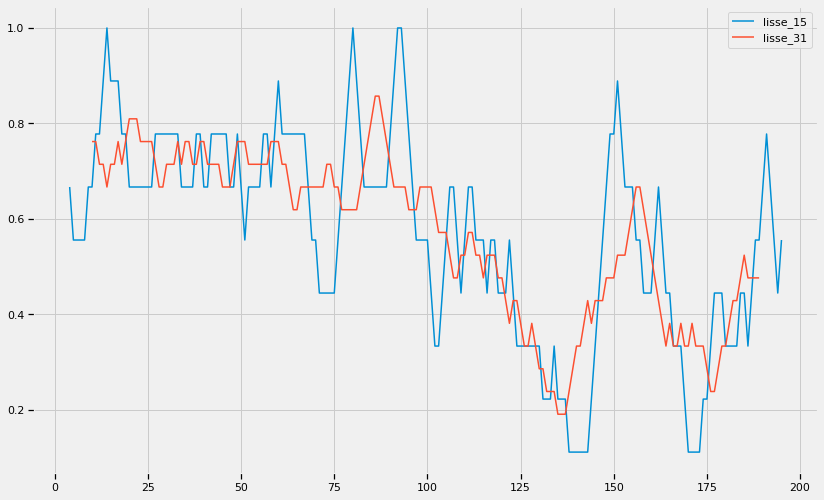

In [56]:
df[["lisse_15","lisse_31"]].plot(figsize=(12.5, 8))